In [20]:
from __future__ import print_function, division

%matplotlib inline
%precision 3
import random
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import random
import networkx as nx
import numpy as np
import copy

# import thinkplot

In [21]:
class Student(object):
    """ 
    Base student; used as node in network. 
    """

    def __init__(self, immune_strength=5, tolerance=50):
        self.immune_strength = immune_strength #rate of lowering exposure
        self.tolerance = tolerance # value at which is_sick
        self.exposure = 0
        self.is_sick = 0 # 0: not sick; 1: sick; 2: was sick already
        
    def process_exposure(self):
        if self.is_sick == 2:
            return
        self.exposure -= self.immune_strength
        
        if self.is_sick == 1:
            if self.exposure <= 0:
                self.is_sick = 2
        elif self.is_sick == 0:
            if self.exposure >= self.tolerance:
                self.is_sick = 1


In [22]:
def create_student_ba_graph(size=50, new_edges_per_node=3, roommate=True):
    """ 
    Creates a graph of [size] Student nodes, using weighted connections.
    Eventually, efficiency might be a concern here. Should be fine
    for n=90, though.
    TODO: vary the edges new nodes introduce.
    TODO: roommates, relationships, etc - "colored" edges.
    """
    G = nx.Graph()
    if size <= 0:
        return G
    
    first_student = Student()
    G.add_node(first_student)
    
    students_list = []
    students_list.append([first_student,0])
    
    for i in range(size):
        new_student = Student(
            immune_strength = random.randint(4,8), 
            tolerance = random.randint(40,80));
        G.add_node(new_student)
        all_students = range(len(students_list))
        probs_base = [float(k[1]+1) for k in students_list]
        probs = probs_base/np.sum(probs_base)
        number_of_friends = min(len(students_list), new_edges_per_node)
        new_friends = np.random.choice(all_students, size=number_of_friends, replace=False, p=probs)
        for friend in new_friends:
            students_list[friend][1] += 1
            G.add_edge(new_student, students_list[friend][0])
        students_list.append([new_student, nx.degree(G, new_student)])

        
    social = {}
    for edge in G.edges():
        social[edge] = random.randint(1,10)
        
    nx.set_edge_attributes(G, "social", social)
    #Create Roommates
    if roommate == True:
        F = G.copy()
        G = create_Roommates(G)
    
    return G,F

def create_Roommates(G):
    all_nodes = G.nodes() #i removed the [:] because it seemed vestigial
    random.shuffle(all_nodes)
    for i in range(len(all_nodes) // 2):
        first_roommate = all_nodes[2*i]
        second_roommate = all_nodes[(2*i) + 1]
        if not G.has_edge(first_roommate, second_roommate):
            G.add_edge(first_roommate, second_roommate)
            this_pair = G[first_roommate][second_roommate]
            this_pair["social"] = 20
        else:
            this_pair = G[first_roommate][second_roommate]
            this_pair["social"] = 20
    return G


def draw_sickness_graph(G, pos):
    """ 
    Draws a graph, with red as sick, 
    blue as recovered, 
    green as never sick? colors are iffy right now.
    """
    sick_nodes = [node for node in G.nodes() if node.is_sick == 1]
    recovered_nodes = [node for node in G.nodes() if node.is_sick == 2]
    healthy_nodes = [node for node in G.nodes() if node.is_sick == 0]

    nx.draw_networkx_nodes(G, pos, nodelist=sick_nodes, node_color='r')
    nx.draw_networkx_nodes(G, pos, nodelist=healthy_nodes, node_color='g')
    nx.draw_networkx_nodes(G, pos, nodelist=recovered_nodes, node_color='b')
    nx.draw_networkx_edges(G, pos)
    plt.axis('off')
    plt.show()

In [23]:
def step(G):
    total_sick = 0
    for node in G.nodes():
        if node.is_sick == 0:
            for neighbor in G.neighbors(node):
                if neighbor.is_sick == 1:
                    node.exposure += G[node][neighbor]["social"]
        elif node.is_sick == 1:
            total_sick += 1
    for node in G.nodes():
        node.process_exposure() #separate step
    
    return total_sick

In [24]:
# G, F = create_student_ba_graph()
# G_positions = nx.drawing.spring_layout(G[0]) 
# draw_sickness_graph(G[0], G_positions)

In [25]:
# patient_zero = random.choice(G.nodes())
# patient_zero.exposure = 100
# patient_zero.is_sick = 1
# draw_sickness_graph(G, G_positions)

In [26]:
# for i in range(10):
#     step(G)
# draw_sickness_graph(G, G_positions)

In [27]:
    #needs to be converted to serve our code
    #TODO make this work
    def animate(frames=20, interval=200, grid=False):
        """Creates an animation.

        frames: number of frames to draw
        interval: time between frames in ms
        """
        fig = draw_sickness_graph(G, G_positions)
        self.draw(grid)
        anim = animation.FuncAnimation(fig, animate_func,
                                       init_func=init_func,
                                       frames=frames, interval=interval)
        return anim

    def init_func():
        """Called at the beginning of an animation."""
        pass

    def animate_func(i):
        """Draws one frame of the animation."""
        if i > 0:
            self.step()
        a = self.viewee.array
        self.im.set_array(a)
        return (self.im,)

In [28]:
def run_graph(graph, iters):
    #instantiate patient zero being the same node in both 
    patient_zero = graph.nodes()[0]
    patient_zero.exposure = 100
    patient_zero.is_sick = 1

    sick = []
    time_step = []
    for i in range(iters):
        sick.append(step(graph))
        time_step.append(i)
    return sick, time_step

In [29]:
#instantiate the graphs
graphs = create_student_ba_graph()
#G has roommates, F does not
G = graphs[0]
F = graphs[1]
#run the model a certain number of steps for roommate pairs and without
sickG,time_stepG = run_graph(G.copy(),50)
sickF,time_stepF = run_graph(F.copy(),50)
    

NameError: name 'time_step' is not defined

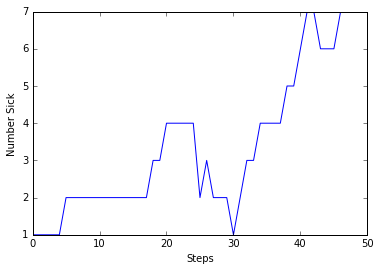

In [30]:
import matplotlib.pyplot as plt
plt.plot(time_stepG,sickG)
plt.ylabel('Number Sick')
plt.xlabel('Steps')
plt.axis([0, time_step[-1], 0, max(sick)+5])
plt.title('Roommates')
plt.show()

plt.plot(time_stepF,sickF)
plt.ylabel('Number Sick')
plt.xlabel('Steps')
plt.axis([0, time_step[-1], 0, max(sick)+5])
plt.title('No Roommates')
plt.show()

In [31]:
def run_lots(G,F,iters,total):
    #where G is graph one, F is graph 2, iters is the number of steps in each run, total is the total number of runs
    maxG = []
    maxF = []
    avgG = []
    avgF = []
    for i in range(total):
        sickG,time_stepG = run_graph(G.copy(),iters)
        sickF,time_stepF = run_graph(F.copy(),iters)
        maxG.append(max(sickG))
        maxF.append(max(sickF))
        avgG.append(sum(sickG)/len(sickG))
        avgF.append(sum(sickF)/len(sickF))
    return maxG,avgG,maxF,avgF

In [32]:
def frequencyFinder(stats):
    res = {}
    for i in stats:
        if i not in res:
            res[i] = 1
        else:
            res[i] +=1
    
    keys = sorted(res.keys())
    values = []
    for key in keys:
        values.append(res[key])
    return keys,values
        

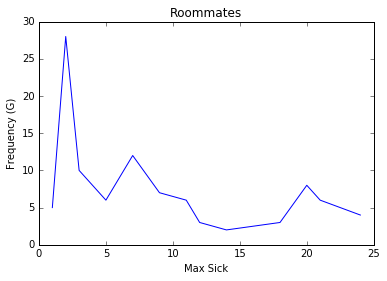

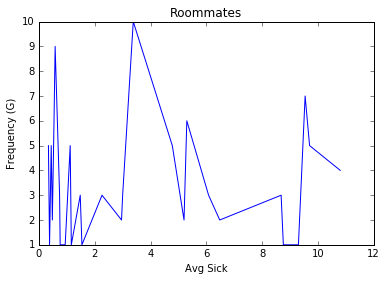

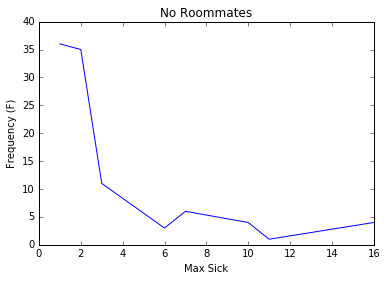

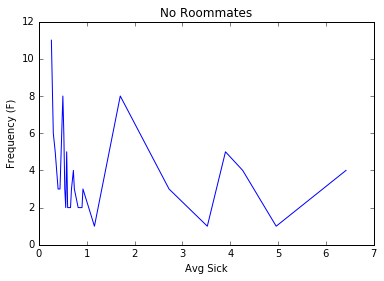

In [33]:
a,b,c,d = run_lots(G,F,50,100)
# print('Max for G: ', a)
# print('Average for G: ',b)
# print('Max for F: ',c)
# print('Average for F: ',d)

keya,vala = frequencyFinder(a)
keyb,valb = frequencyFinder(b)
keyc,valc = frequencyFinder(c)
keyd,vald = frequencyFinder(d)


plt.plot(keya,vala)
plt.ylabel('Frequency (G)')
plt.xlabel('Max Sick')
plt.title('Roommates')
plt.show()

plt.plot(keyb,valb)

plt.ylabel('Frequency (G)')
plt.xlabel('Avg Sick')
plt.title('Roommates')
plt.show()

plt.plot(keyc,valc)
plt.ylabel('Frequency (F)')
plt.xlabel('Max Sick')
plt.title('No Roommates')
plt.show()

plt.plot(keyd,vald)
plt.ylabel('Frequency (F)')
plt.xlabel('Avg Sick')
plt.title('No Roommates')
plt.show()

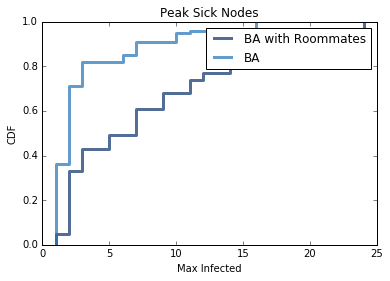

In [34]:
import thinkplot
import thinkstats2
thinkplot.Cdf(thinkstats2.Cdf(a), label="BA with Roommates")
thinkplot.Cdf(thinkstats2.Cdf(c), label="BA")
thinkplot.config(xlabel='Max Infected', ylabel='CDF',title="Peak Sick Nodes")

In [ ]:
import thinkplot
import thinkstats2
thinkplot.Cdf(thinkstats2.Cdf(b), label="BA with Roomates")
thinkplot.Cdf(thinkstats2.Cdf(d), label="BA")
thinkplot.config(xlabel='Average Infected', ylabel='CDF',title="Average Sick Nodes")

In [ ]:
class MeaslesStudent(object):
    """ 
    Base student; used as node in network. 
    """

    def __init__(self, immune_strength=5, tolerance=50, totalUnaware=1):
        self.immune_strength = immune_strength #rate of lowering exposure
        self.tolerance = tolerance # value at which is_sick
        self.exposure = 0
        self.is_sick = 0 # 0: not sick; 1: sick; 2: was sick already; 3: infectious but unaware
        self.days_unaware = 0
        self.total_unaware = totalUnaware 
        
    def process_exposure(self):
        if self.is_sick == 2:
            return
        self.exposure -= self.immune_strength
        
        if self.is_sick == 1:
            if self.exposure <= 0:
                self.is_sick = 2
        elif self.is_sick == 0:
            if self.exposure >= self.tolerance:
                self.is_sick = 3
        elif self.is_sick == 3:
            self.days_unaware += 1
            if self.days_unaware >= self.total_unaware:
                self.is_sick = 1

In [ ]:
def create_student_ba_graph(size=50, new_edges_per_node=3, roommate=True):
    """ 
    Creates a graph of [size] Student nodes, using weighted connections.
    Eventually, efficiency might be a concern here. Should be fine
    for n=90, though.
    TODO: make it return two graphs from the same seed, one made with no incubation period and one with one.
    """
    G = nx.Graph()
    if size <= 0:
        return G
    
    first_student = MeaslesStudent()
    G.add_node(first_student)
    
    students_list = []
    students_list.append([first_student,0])
    
#     F = G.copy()
    
    for i in range(size):
        im = random.randint(4,8)
        tol = random.randint(40,80)
        new_student = MeaslesStudent(
            immune_strength = im, 
            tolerance = tol,
            totalUnaware = 4);
        G.add_node(new_student)
        all_students = range(len(students_list))
        probs_base = [float(k[1]+1) for k in students_list]
        probs = probs_base/np.sum(probs_base)
        number_of_friends = min(len(students_list), new_edges_per_node)
        new_friends = np.random.choice(all_students, size=number_of_friends, replace=False, p=probs)
        for friend in new_friends:
            students_list[friend][1] += 1
            G.add_edge(new_student, students_list[friend][0])
        students_list.append([new_student, nx.degree(G, new_student)])

        
    social = {}
    for edge in G.edges():
        social[edge] = random.randint(1,10)
        
    nx.set_edge_attributes(G, "social", social)
    #Create Roommates
    if roommate == True:
#         
        G = create_Roommates(G)
    
    F = G.copy() #deepcopy perhaps?
    for node in F.nodes():
        im_s = int(node.immune_strength)
        tol = int(node.tolerance)
        node = Student(immune_strength = im_s, tolerance = tol)
        
    
    return G,F



def create_Roommates(G):
    all_nodes = G.nodes() 
    random.shuffle(all_nodes)
    for i in range(len(all_nodes) // 2):
        first_roommate = all_nodes[2*i]
        second_roommate = all_nodes[(2*i) + 1]
        if not G.has_edge(first_roommate, second_roommate):
            G.add_edge(first_roommate, second_roommate)
            this_pair = G[first_roommate][second_roommate]
            this_pair["social"] = 20
        else:
            this_pair = G[first_roommate][second_roommate]
            this_pair["social"] = 20
    return G

def step(G):
    total_sick = 0
    for node in G.nodes():
        if node.is_sick == 0:
            for neighbor in G.neighbors(node):
                if neighbor.is_sick == 1:
                    node.exposure += G[node][neighbor]["social"]
        elif node.is_sick == 1 or node.is_sick == 3:
            total_sick += 1
    for node in G.nodes():
        node.process_exposure() #separate step
    
    return total_sick

In [ ]:
def step(G):
    total_sick = 0
    for node in G.nodes():
        if node.is_sick == 0:
            for neighbor in G.neighbors(node):
                if neighbor.is_sick == 1:
                    node.exposure += (G[node][neighbor]["social"]/2) #todo: differentiate for student plain.
                if neighbor.is_sick == 3:
                    node.exposure += G[node][neighbor]["social"]
                    
        elif node.is_sick == 1 or node.is_sick == 3:
            total_sick += 1
    for node in G.nodes():
        node.process_exposure() #separate step
    
    return total_sick

def run_graph(graph, iters):
    #instantiate patient zero being the same node in both 
    patient_zero = graph.nodes()[0]
    patient_zero.exposure = 100
    patient_zero.is_sick = 1

    sick = []
    time_step = []
    for i in range(iters):
        sick.append(step(graph))
        time_step.append(i)
    return sick, time_step

In [15]:
#instantiate the graphs
graphs = create_student_ba_graph()
#G has roommates, F does not
G = graphs[0]
F = graphs[1]
#run the model a certain number of steps for roommate pairs and without
sickG,time_stepG = run_graph(G.copy(),50)
sickF,time_stepF = run_graph(F.copy(),50)
    

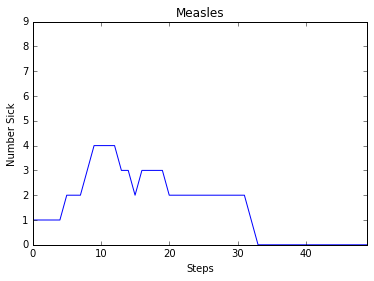

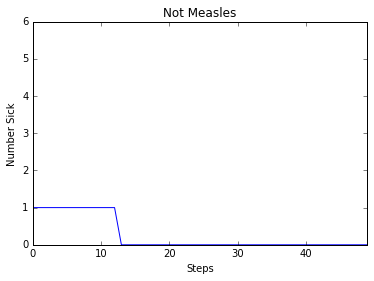

In [16]:
plt.plot(time_stepG,sickG)
plt.ylabel('Number Sick')
plt.xlabel('Steps')
plt.axis([0, time_stepG[-1], 0, max(sickG)+5])
plt.title('Measles')
plt.show()

plt.plot(time_stepF,sickF)
plt.ylabel('Number Sick')
plt.xlabel('Steps')
plt.axis([0, time_stepF[-1], 0, max(sickF)+5])
plt.title('Not Measles')
plt.show()

In [35]:
iters = 50
total = 100

maxG, avgG, maxF, avgF = run_lots(G.copy(),F.copy(),iters,total)

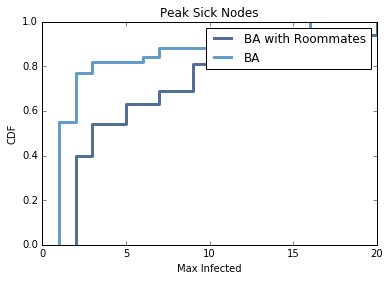

In [36]:
thinkplot.Cdf(thinkstats2.Cdf(maxG), label="BA with Roommates")
thinkplot.Cdf(thinkstats2.Cdf(maxF), label="BA")
thinkplot.config(xlabel='Max Infected', ylabel='CDF',title="Peak Sick Nodes")

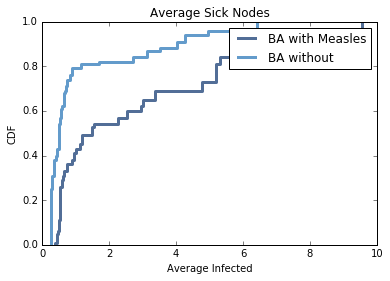

In [37]:
thinkplot.Cdf(thinkstats2.Cdf(avgG), label="BA with Measles")
thinkplot.Cdf(thinkstats2.Cdf(avgF), label="BA without")
thinkplot.config(xlabel='Average Infected', ylabel='CDF',title="Average Sick Nodes")